In [2]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,547 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,538 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,298 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubunt

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hyperparameters


In [4]:
env_name = "CartPole-v0"
num_iterations = 100
collect_episodes_per_iteration = 2
replay_buffer_capacity = 2000
fc_layer_params =(100,)
learning_rate = 1e-3
# ???
log_interval = 25
num_eval_episodes = 10
# ???
eval_interval = 50


# Environment


In [21]:
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


The time_step = environment.step(action) statement takes action in the environment. The TimeStep tuple returned contains the environment's next observation and reward for that action. The time_step_spec() and action_spec() methods in the environment return the specifications (types, shapes, bounds) of the time_step and action respectively.

In [22]:
time_step = env.reset()
print('Time step:', time_step)
action  = np.array(1, dtype=np.int32)
next_time_step = env.step(action)
print('Time step:', next_time_step)


Time step: TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0019466 ,  0.02567801, -0.01482228,  0.04352996], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Time step: TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00246016,  0.22100933, -0.01395168, -0.25379243], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [23]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


# Agent


In [24]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# this keeps track of how many times the network has updated
train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network = actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter
)
tf_agent.initialize()

In [25]:
eval_policy = tf_agent.policy # used for actual eval and deployment
collect_policy = tf_agent.collect_policy # used for data collection

# Metrics and Evaluation

In [26]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for epi in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Replay Buffer


In [28]:
# Using Reverb from Deepmind to efficiently keep track of previous experiences
table_name = 'uniform_table'
# ??? tensor spec, from spec, add outer dim
replay_buffer_signature = tensor_spec.from_spec(tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover= reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name = table_name,
    sequence_length=None,
    local_server=reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)


# Data Collection


In [29]:
def collect_episode(environment, policy, num_episodes):
  driver = py_driver.PyDriver(
      environment,
      py_tf_eager_policy.PyTFEagerPolicy(
          policy, use_tf_function=True),
          [rb_observer],
          max_episodes = num_episodes
      )
  initial_time_step = environment.reset()
  driver.run(initial_time_step)


# Training


In [32]:
try:
  %%time
except:
  pass

tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)



step = 25: loss = 1.3565795421600342
step = 50: loss = 2.1609420776367188
step = 50: Average Return = 142.6999969482422
step = 75: loss = 1.7962543964385986
step = 100: loss = 2.569929361343384
step = 100: Average Return = 132.1999969482422


(60.27499694824219, 250.0)

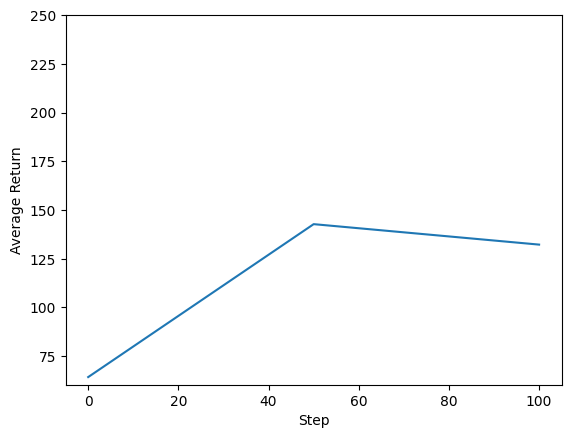

In [33]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [34]:
def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [36]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_py_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())


embed_mp4(video_filename)
